In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.regularizers import l2
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Loading the dataset
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [5]:
#Getting the shape of the dataframe
df.shape

(9823, 7)

In [7]:
#Date Pre-processing
#Getting basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [9]:
#Date column is in object data type so converting it into datatime data type
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
#Checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9823 non-null   datetime64[ns]
 1   Open       9822 non-null   float64       
 2   High       9822 non-null   float64       
 3   Low        9822 non-null   float64       
 4   Close      9822 non-null   float64       
 5   Adj Close  9822 non-null   float64       
 6   Volume     9822 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 537.3 KB


In [13]:
#Setting Date column as index
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [15]:
#Checking null values
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [17]:
#There is one missing value - Since Stock prices are sequential, dropping values is not the best approach
#Using Forward Fill(Where it fills with the previous days values)

df.fillna(method='ffill',inplace=True)

In [19]:
#Checking for null values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [21]:
#Data Preparation for modelling
#Using Min-Max scaler as neural networks works best when features are scaled

#Selecting 'Adj Close' Column
adj_close = df[['Adj Close']]

#Initializing the Scaler
scaler = MinMaxScaler(feature_range=(0,1))

#Fitting and transforming the adj close column
df_scaled = scaler.fit_transform(adj_close)

#Converting it into DataFrame
df_scaled = pd.DataFrame(df_scaled,index=df.index,columns=['Adj Close'])

#Checking new DataFrame
df_scaled.head()

,Adj Close
Date,
1980-12-12,0.000943
1980-12-15,0.000863
1980-12-16,0.000757
1980-12-17,0.000790
1980-12-18,0.000830


In [23]:
#Creating time series sequences
def create_sequences(data,time_steps):
    X,y = [],[]
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X),np.array(y)

In [25]:
#Defining the time_steps
time_steps = 60

#Calling the function
X,y = create_sequences(df_scaled.values,time_steps)

print(f"X Shape: {X.shape}, y Shape: {y.shape}")

X Shape: (9763, 60, 1), y Shape: (9763, 1)


In [35]:
#Reshaping X to be suitable for LSTM
X = X.reshape(X.shape[0],X.shape[1],1)

In [37]:
#Using train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,shuffle = False)

print(f"X_train shape :{X_train.shape},X_test shape:{X_test.shape}")

X_train shape :(7810, 60, 1),X_test shape:(1953, 60, 1)


In [65]:
#Defining LSTM Model
model = Sequential([
    LSTM(units=30,return_sequences=True,activation='relu',input_shape = (X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(units=20,return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
         

In [67]:
#Model Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 60, 30)              │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20)                  │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471 (33.09 KB)

 Trainable params: 8,471 (33.09 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#Compiling the Model
optimizer = Adam(learning_rate = 0.0003)

#Compiling the model
model.compile(optimizer=optimizer,loss='mean_squared_error')

In [71]:
#Defining early stopping and Model checkpoint
early_stopping = EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True)
model_checkpoint = ModelCheckpoint("AAPL_LSTM.h5",save_best_only=True,monitor='val_loss')

#Training the model
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping,model_checkpoint],
    verbose = 1
)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.7070e-04

123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 7.6717e-04 - val_loss: 5.8352e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.4491e-05 - val_loss: 8.7255e-04
Epoch 3/50
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8920e-05

123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8923e-05 - val_loss: 5.5100e-04
Epoch 4/50
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5553e-05

123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5501e-05 - val_loss: 5.2923e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 3.9681e-05 - val_loss: 5.4690e-04
Epoch 6/50
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.5017e-05

123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 4.4958e-05 - val_loss: 4.5875e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 3.8540e-05 - val_loss: 7.1197e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4.0428e-05 - val_loss: 5.6433e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 3.2524e-05 - val_loss: 7.3788e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.2166e-05 - val_loss: 6.4487e-04
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 3.5883e-05 - val_loss: 0.0017
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.4499e-05 - val_loss: 6.1829e-04
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 3.2647e-05 - val_loss: 0.0011


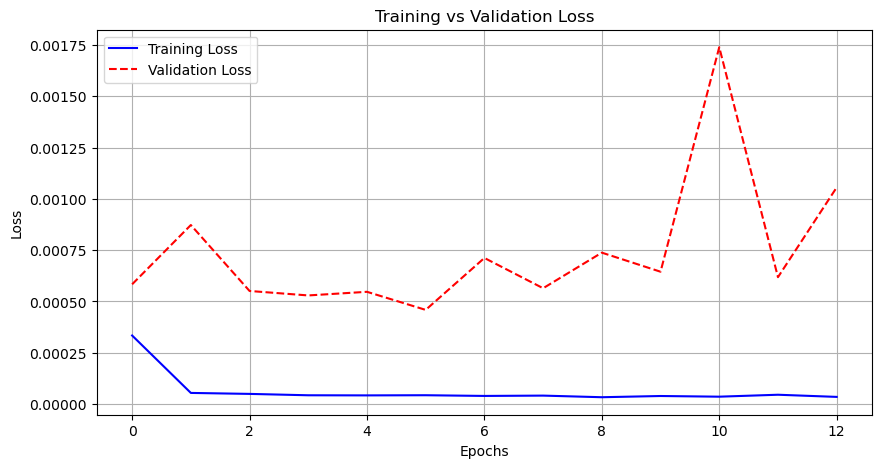

In [73]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [75]:
#Predicting the stock prices for the test data
pred_stock_prices = model.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [77]:
#Converting predictions back to actual prices
pred_stock_prices = scaler.inverse_transform(pred_stock_prices)
actual_stock_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [79]:
#Calculating MSE 
mse = mean_squared_error(actual_stock_prices,pred_stock_prices)
print(f"Mean Squared Error(MSE) : {mse}")

Mean Squared Error(MSE) : 32.68996681346626


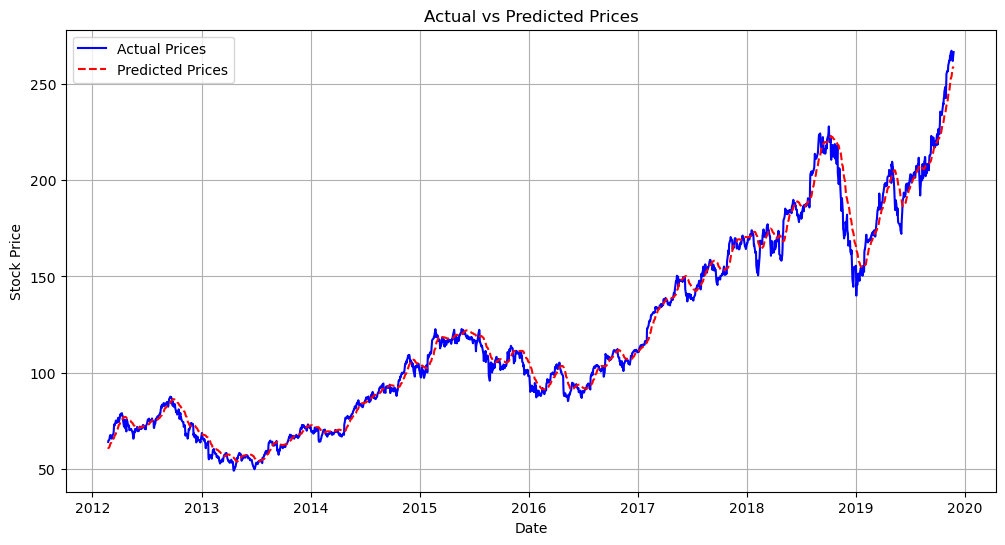

In [81]:
#Visualizing the actual and predicted stock prices
dates = df.index[-len(actual_stock_prices):]
plt.figure(figsize=(12,6))
plt.plot(dates,actual_stock_prices,label = 'Actual Prices',color = 'blue')
plt.plot(dates,pred_stock_prices,label = 'Predicted Prices', color='red',linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()

In [85]:
def predict_next_day(model, last_sequence, scaler):

    # Reshaping last sequence to match model input shape (1, 60, 1)
    last_sequence = last_sequence.reshape(1, last_sequence.shape[0], 1)

    # Predicting next day's price 
    predicted_scaled = model.predict(last_sequence)

    # Using Inverse transform to get actual price
    next_day_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0, 0]

    return next_day_price


# Extracting the last sequence from X_test
last_sequence = X_test[-1]  # This takes the last available sequence
print(f"Last sequence shape: {last_sequence.shape}")

# Flatten it to shape (60,)
last_sequence = last_sequence.flatten()
print(f"After flattening: {last_sequence.shape}") 

# Predict the next day's price
next_day_price = predict_next_day(model, last_sequence, scaler)
print(f"Predicted stock price for the next day: ${next_day_price:.5f}")


Last sequence shape: (60, 1)
After flattening: (60,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted stock price for the next day: $258.90182


In [87]:
def predict_next_5_days(model, last_sequence, scaler):

    predictions = []
    current_sequence = last_sequence.copy()  # Copying to avoid modifying original

    for _ in range(5):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)

        # Predict next day's price
        predicted_scaled = model.predict(current_sequence_reshaped)
        predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0, 0]

        # Storing the prediction
        predictions.append(predicted_price)

        # Update sequence: remove first value, append predicted value
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = predicted_scaled  # Append new prediction

    return predictions

# Predicting stock prices for the next 5 days
next_5_days_prices = predict_next_5_days(model, last_sequence, scaler)
print(f"Predicted stock prices for the next 5 days: ${next_5_days_prices}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted stock prices for the next 5 days: $[258.90182, 259.44122, 259.85733, 260.17947, 260.43213]


In [89]:
def predict_next_10_days(model,last_sequence,scaler):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(10):
        current_sequence_reshaped = current_sequence.reshape(1,current_sequence.shape[0],1)

        #Predicting next day's prices
        predicted_scaled = model.predict(current_sequence_reshaped)
        predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1,1))[0,0]

        #Storing the predictions
        predictions.append(predicted_price)

        # Updating sequence: remove first value, append predicted value
        current_sequence = np.roll(current_sequence,-1)
        current_sequence[-1] = predicted_scaled    #appending new prediction

    return predictions

next_10_days_prices = predict_next_10_days(model,last_sequence,scaler)
print(f"Predicted Stock prices fot the next 10 days: {next_10_days_prices}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Stock prices fot the next 10 days: [258.90182, 259.44122, 259.85733, 260.17947, 260.43213, 260.63406, 260.79886, 260.9366, 261.05475, 261.1587]


In [91]:
#Saving the model
model.save("Final_AAPL_LSTM.h5")